# 나만의 천재 작사가 만들기 🎶

<br>

## 목차
1. 데이터 전처리
2. 모델 설계 및 학습
3. 모델 평가
4. 결론 및 회고

In [14]:
# 필요한 모듈 불러오기
import glob
import os
import random
import re

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
%matplotlib inline

## 1. 데이터 전처리

### 1-1. 데이터 불러오기

In [4]:
# 데이터 불러오기
txt_file_path = os.getenv('HOME') + '/aiffel/aiffel_projects/data/lyricist/data/lyrics/*'
txt_list = glob.glob(txt_file_path)

raw_corpus = []

# 모든 txt파일의 데이터를 문장 단위로 raw_corpus 리스트에 저장하기
for txt_file in txt_list:
    with open(txt_file, 'r') as f:
        raw = f.read().splitlines()
        raw_corpus.extend(raw)
        
        
print("데이터 크기:", len(raw_corpus))
print("\n------------------------------------\n")

# 데이터 정제하기 전에 미리 살펴보기
print("Examples:\n", raw_corpus[:30])

데이터 크기: 187088

------------------------------------

Examples:
 ['At first I was afraid', 'I was petrified', 'I kept thinking I could never live without you', 'By my side But then I spent so many nights', "Just thinking how you've done me wrong", 'I grew strong', "I learned how to get along And so you're back", 'From outer space', 'I just walked in to find you', 'Here without that look upon your face I should have changed that fucking lock', 'I would have made you leave your key', 'If I had known for just one second', "You'd be back to bother me Well now go,", 'Walk out the door', 'Just turn around', "Now, you're not welcome anymore Weren't you the one", 'Who tried to break me with desire?', "Did you think I'd crumble?", "Did you think I'd lay down and die? Oh not I,", 'I will survive', 'Yeah', "As Long as I know how to love, I know I'll be alive", "I've got all my life to live", "I've got all my love to give", 'I will survive, I will survive', 'Yeah, yeah', 'It took all the strength 

### 1-2. 데이터 정제

- preprocess_sentence() 함수를 정의하여 사용했다.
- parameter로 입력 받은 각 문장별로 아래 기능을 수행한다.
    - 일괄 소문자로 바꾸기 ------------------> lower()
    - 양쪽 공백 삭제 ---------------------------> strip()
    - 모든 특수문자는 공백으로 대체 ------------> re.sub()
    - (특수문자에는 문장 부호가 포함됨)
    - 여러 개 공백은 1개로 대체 ------------> re.sub()
    - 문장의 시작에 \<start\>, 끝에는 \<end\> 추가

- **사실 단어 중간에 들어가는 '-'를 삭제해서 하나의 단어로 만들고 싶었으나, 노래 가사라는 특성 때문에 'yeah-yeah-'와 같은 경우가 다수 있는 것을 발견하였다. 때문에 삭제하지 않고 공백으로 대체하였다.**

In [5]:
# 입력 받은 문장을 기준에 맞게 정제해주는 함수
def preprocess_sentence(sentence):
    sentence = sentence.lower().strip()
    sentence = re.sub(r'[" "]+', " ", sentence)
    sentence = re.sub(r"[^a-zA-Z]+", " ", sentence)
    sentence = sentence.strip()
    sentence = '<start> ' + sentence + ' <end>'
    return sentence

In [6]:
# corpus 리스트에 정제된 문장 모으기
corpus = []

for sentence in raw_corpus:
    if len(sentence) == 0: continue
    
    preprocessed = preprocess_sentence(sentence)
    corpus.append(preprocessed)

print("정제된 문장 개수:", len(corpus))

정제된 문장 개수: 175986


In [7]:
# random으로 문장 불러와서 확인해보기
rand_corp = random.sample(corpus, 20)
rand_corp

['<start> plain pat what up <end>',
 '<start> those were my demons <end>',
 '<start> feel the pain running through my veins <end>',
 '<start> he used his pipe and she used her legs <end>',
 '<start> for weeks you been talkin about extra bedrooms <end>',
 '<start> yeah we both sang why can t i get one kiss we are forgotten young suburbia <end>',
 '<start> she s cuttin the corners of her eyes <end>',
 '<start> shocking cause i never knew love like this could exist tables are turning <end>',
 '<start> love to explore that shore above <end>',
 '<start> come on come on come on <end>',
 '<start> i hit her with that shovel dick i got in that pussy and dug a ditch <end>',
 '<start> dry cry cause i m hopeless <end>',
 '<start> baby you re sick i want your love <end>',
 '<start> you re perfect to me no matter whatever seems <end>',
 '<start> dying <end>',
 '<start> i want a shot at redemption <end>',
 '<start> she loves you big river more than me now i taught the weeping willow how to cry cry cr

### 1-3. 데이터 토큰화 & 벡터화
- tf.keras.preprocessing.text.Tokenizer를 이용

In [17]:
# corpus를 입력 받아서 토큰화해주는 함수
def tokenize(corpus):
    # 단어 10000개를 기억할 수 있는 tokenizer 생성
    # 10000개에 포함되지 않은 단어는 <unk>로 대체
    # 이미 데이터를 정제했으므로 filters는 제외
    tokenizer = tf.keras.preprocessing.text.Tokenizer(
        num_words=10000,
        filters=' ',
        oov_token="<unk>"
    )
    
    # corpus를 이용해 tokenizer 내부의 단어장 생성
    tokenizer.fit_on_texts(corpus)
    
    # 준비한 tokenizer를 이용해 corpus를 tensor로 변환
    tensor = tokenizer.texts_to_sequences(corpus)
    
    # 입력 데이터의 시퀀스 길이를 일정하게 맞추기
    # 만약 시퀀스가 짧다면 문장 뒤(post)에 패딩(0)을 붙임
    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')
    
    print(tensor, tokenizer)
    return tensor, tokenizer

tensor, tokenizer = tokenize(corpus)

[[   2   67  237 ...    0    0    0]
 [   2    4   54 ...    0    0    0]
 [   2    4 1083 ...    0    0    0]
 ...
 [   2   45   15 ...    0    0    0]
 [   2    4   20 ...    0    0    0]
 [   2    5  177 ...    0    0    0]] <keras_preprocessing.text.Tokenizer object at 0x7f9ccb8bb290>


<hr>

### ⚠ 그런데 문제가 생겼다!

- 지나치게 긴 문장들이 포함되어 있어서 각 tensor의 길이가 무려 331개에 달하며,
- 대부분의 문장에 0이 지나치게 많아지면서 data의 질이 떨어졌다.

In [18]:
# tensor 길이 확인
print(tensor[0,])
print("\n-----------------------------\n")
print("tensor length:", len(tensor[0,]))

[  2  67 237   4  54 661   3   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   

<function matplotlib.pyplot.show(close=None, block=None)>

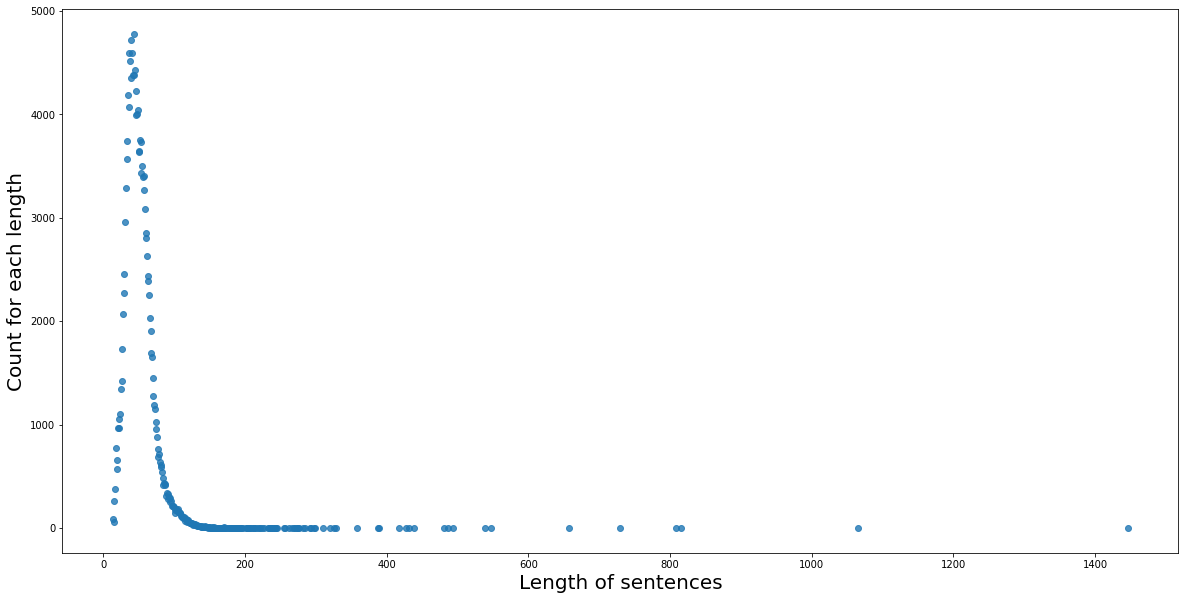

In [22]:
# 각 문장의 길이가 어떤 분포로 구성되어 있는지 그래프를 그려서 살펴보자!
# 우선 각 문장의 length와 해당 length를 가진 문장의 개수를 dictionary에 저장한다
# len_dict = {'문장 길이': 해당 문장 개수}
len_dict = {}

for cor in corpus:
    if len(cor) in len_dict:
        len_dict[len(cor)] += 1
    else:
        len_dict[len(cor)] = 1        
        

length = len_dict.keys()
count = len_dict.values()

# 문장의 길이와 해당하는 개수를 scatter graph로 그려보기
plt.figure(figsize=(20, 10))
plt.xlabel('Length of sentences', fontsize=20)
plt.ylabel('Count for each length', fontsize=20)
plt.scatter(length, count, alpha=0.8)
plt.show

<br>

### 👉 대부분의 데이터가 길이 200 이내에 분포하고 있음을 확인할 수 있다.

In [9]:
# 문장의 길이가 긴 것들을 직접 출력해서 실체를 확인해보자
# 미리 확인한 결과 길이가 200이 넘는 문장은 80개, 150이 넘는 문장은 총 228개가 있다
cnt = 0

for idx, cor in enumerate(corpus):
    if len(cor) >= 150:
        cnt += 1
        
        # 임의로 idx 범위를 지정해서 문장 몇 개만 출력해보기
        if idx > 100 and idx < 10000:
            print(cor)

print("\n--------------------------------------------------\n")
print("길이가 150 초과인 문장의 개수:", cnt)

<start> if you ever lose your way we are building a religion we are building it bigger we are building a religion a limited edition we are now accepting callers <end>
<start> strategize this presentation make them see that you re the man man man man you ll receive the federal funding you can pass the simple test <end>
<start> yo would you kill for me hmmm yeah what took you so long to answer motherfucker i dont know the fuck wrong with you bitch when i met you i admit my first thoughts was to trick <end>
<start> i treat you right you talk slick i beat you right just me and my bitch but you know you love that ass dont you yeah no question no question yo let me ask you another question what you ever fuck around on me why would i do that yo dont lie to me motherfucker moonlight strolls with the hoes oh no thats not my steelo <end>
<start> squeeze your clip hit the right one pass that weed i got to light one in the middle it it ima bring nixgas more drama than their baby mommas <end>

----

<br>
<br>

### 불필요하게 긴 문장들인 것 같다. 전체 길이가 150 이상인 문장들은 리스트에서 삭제하자!

In [10]:
# 전체 길이가 150 이상인 문장들을 리스트에서 삭제
final_corpus = []
cnt = 0

for cor in corpus:
    if len(cor) < 150:
        final_corpus.append(cor)
    else:
        cnt += 1
        
print("삭제한 문장 개수: ", cnt)
print("최종 문장 개수:", len(final_corpus))

삭제한 문장 개수:  238
최종 문장 개수: 175748


In [25]:
# final_corpus를 적용해 토큰화를 다시 진행
tensor, tokenizer = tokenize(final_corpus)

# tensor 길이 확인
print("\n-----------------------------\n")
print("tensor length:", len(tensor[0,]))

[[   2   67  237 ...    0    0    0]
 [   2    4   54 ...    0    0    0]
 [   2    4 1088 ...    0    0    0]
 ...
 [   2   45   15 ...    0    0    0]
 [   2    4   20 ...    0    0    0]
 [   2    5  176 ...    0    0    0]] <keras_preprocessing.text.Tokenizer object at 0x7f9cc35f7110>

-----------------------------

tensor length: 36


In [12]:
# 가장 많이 등장하는 단어 20개 살펴보기 (그냥)
# <start>, <end> 등은 제외하기 위해 idx = 4부터 출력
for idx in range(20):
    print(f"No.{idx+4}:", tokenizer.index_word[idx+4])

No.4: i
No.5: the
No.6: you
No.7: and
No.8: a
No.9: to
No.10: it
No.11: me
No.12: my
No.13: in
No.14: t
No.15: s
No.16: that
No.17: on
No.18: of
No.19: your
No.20: m
No.21: we
No.22: all
No.23: like


### 1-4. Source & target sentence 나누기
- \<start\>로 시작하는 source sentence와,
- \<end\>로 끝나는 target sentence로 각각 나눠 변수에 할당한다.

In [12]:
# <start>로 시작하는 source sentence 생성
# tensor에서 마지막 토큰 자르기
src_input = tensor[:, :-1]

# <end>로 끝나는 target sentence 생성
# tensor에서 첫 번째 토큰 자르기
tgt_input = tensor[:, 1:]

# 출력해서 확인
print(src_input[0])
print(tgt_input[0])

[  2  67 237   4  54 659   3   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
[ 67 237   4  54 659   3   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]


### 1-5. 데이터셋 객체 생성

- tf.data.Dataset 객체 생성
- tokenizer가 만든 단어사전의 10000개 + \<pad\> 1개

In [26]:
BUFFER_SIZE = len(src_input)
BATCH_SIZE = 256
steps_per_epoch = BUFFER_SIZE // BATCH_SIZE

# tokenizer가 구축한 단어사전의 10000개 + <pad> 1개
VOCAB_SIZE = tokenizer.num_words + 1

# 준비한 데이터 소스로부터 데이터셋 생성
dataset = tf.data.Dataset.from_tensor_slices((src_input, tgt_input))
dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)
dataset

<BatchDataset shapes: ((256, 35), (256, 35)), types: (tf.int32, tf.int32)>

<hr>

## 2. 모델 설계 및 학습

### 2-1. 모델 설계

모델의 구성은 다음과 같다.

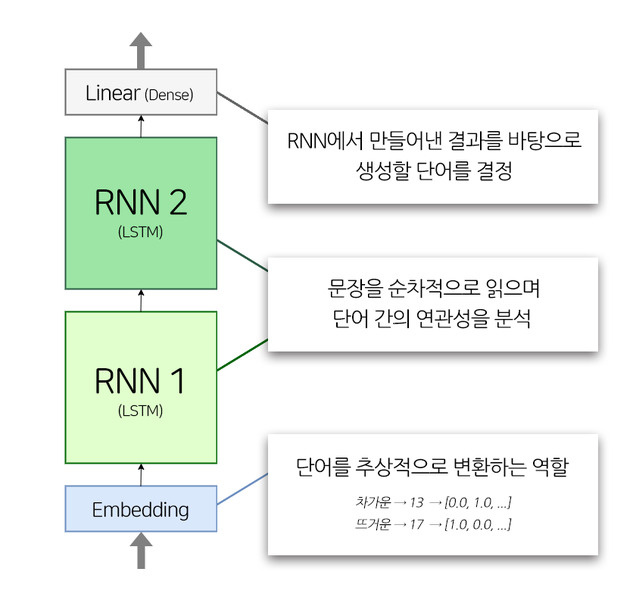

In [29]:
class TextGenerator(tf.keras.Model):
    def __init__(self, vocab_size, embedding_size, hidden_size):
        super().__init__()
        
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_size)
        self.rnn_1 = tf.keras.layers.LSTM(hidden_size, return_sequences=True)
        self.rnn_2 = tf.keras.layers.LSTM(hidden_size, return_sequences=True)
        self.linear = tf.keras.layers.Dense(vocab_size)
        
    def call(self, x):
        out = self.embedding(x)
        out = self.rnn_1(out)
        out = self.rnn_2(out)
        out = self.linear(out)
        
        return out

    
embedding_size = 256
hidden_size = 1024
model = TextGenerator(VOCAB_SIZE, embedding_size, hidden_size)

### 2-2. Validation 데이터셋 분리
- sklearn.model_selection.train_test_split()을 이용
- 전체 중 20%를 validation을 위한 데이터셋으로 분리

In [30]:
# 전체 중 20%를 validation을 위한 데이터셋으로 분리
src_train, src_val, tgt_train, tgt_val = train_test_split(
    src_input, tgt_input,
    test_size=0.2,
    random_state=35
)

# 각 데이터셋 사이즈 확인
print("Source train: ", src_train.shape)
print("Target train: ", tgt_train.shape)
print("Source validation: ", src_val.shape)
print("Target validation: ", tgt_val.shape)

Source train:  (140598, 35)
Target train:  (140598, 35)
Source validation:  (35150, 35)
Target validation:  (35150, 35)


In [31]:
# 학습에 앞서 gpu 사용이 가능한지 확인
tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


True

<br>

### 2-3. 모델 학습

In [32]:
optimizer = tf.keras.optimizers.Adam()
loss = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True,
    reduction='none'
)

model.compile(loss=loss, optimizer=optimizer)
result = model.fit(src_train, tgt_train, validation_data=(src_val, tgt_val), batch_size=BATCH_SIZE, epochs=10)

Epoch 1/10
550/550 [==============================] - 456s 819ms/step - loss: 1.9958 - val_loss: 1.3870
Epoch 2/10
550/550 [==============================] - 762s 1s/step - loss: 1.3568 - val_loss: 1.2874
Epoch 3/10
550/550 [==============================] - 1140s 2s/step - loss: 1.2668 - val_loss: 1.2355
Epoch 4/10
550/550 [==============================] - 1138s 2s/step - loss: 1.2092 - val_loss: 1.1922
Epoch 5/10
550/550 [==============================] - 1141s 2s/step - loss: 1.1634 - val_loss: 1.1569
Epoch 6/10
550/550 [==============================] - 1139s 2s/step - loss: 1.1141 - val_loss: 1.1257
Epoch 7/10
550/550 [==============================] - 1135s 2s/step - loss: 1.0743 - val_loss: 1.0990
Epoch 8/10
550/550 [==============================] - 1139s 2s/step - loss: 1.0327 - val_loss: 1.0762
Epoch 9/10
550/550 [==============================] - 1139s 2s/step - loss: 0.9910 - val_loss: 1.0564
Epoch 10/10
550/550 [==============================] - 1138s 2s/step - loss: 0.95

In [33]:
model.summary()

Model: "text_generator_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      multiple                  2560256   
_________________________________________________________________
lstm_2 (LSTM)                multiple                  5246976   
_________________________________________________________________
lstm_3 (LSTM)                multiple                  8392704   
_________________________________________________________________
dense_1 (Dense)              multiple                  10251025  
Total params: 26,450,961
Trainable params: 26,450,961
Non-trainable params: 0
_________________________________________________________________


<hr>

## 3. 모델 평가

### 3-1. loss와 val_loss 평가

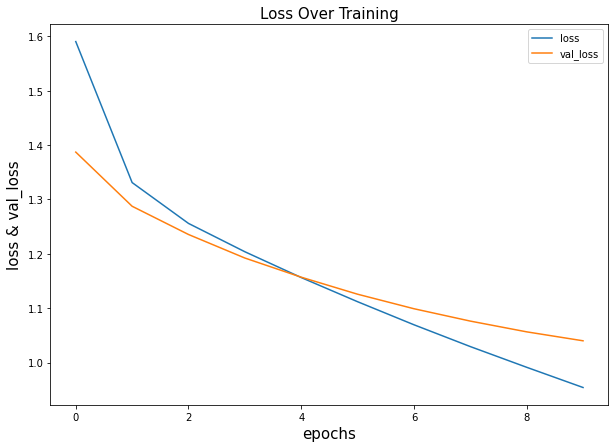

In [35]:
fig = plt.figure(figsize=(10, 7))

plt.plot(result.history['loss'])
plt.plot(result.history['val_loss'])

plt.title('Loss Over Training', fontsize=15)
plt.xlabel('epochs', fontsize=15)
plt.ylabel('loss & val_loss', fontsize=15)
plt.legend(['loss','val_loss'])

plt.show()

#### ※ 최종 Loss 결과
- epochs: 10
- loss: 0.9550
- val_loss: 1.0400

<br>

사실 epochs를 조금 더 늘려서 training하면 더 낮은 val_loss를 얻을 수 있을 것 같은데, 시간을 고려해 여기서 만족하기로 했다.

### 3-2. 직접 작사 실력 확인하기

In [58]:
def generate_text(model, tokenizer, init_sentence="<start>", max_len=100):
    # 테스트를 위해서 입력받은 init_sentence도 텐서로 변환
    test_input = tokenizer.texts_to_sequences([init_sentence])
    test_tensor = tf.convert_to_tensor(test_input, dtype=tf.int64)
    end_token = tokenizer.word_index["<end>"]

    # 단어 하나씩 예측해 문장을 만든다
    #    1. 입력받은 문장의 텐서를 입력
    #    2. 예측된 값 중 가장 높은 확률인 word index를 뽑아낸다
    #    3. 2에서 예측된 word index를 문장 뒤에 붙인다
    #    4. 모델이 <end>를 예측했거나, max_len에 도달했다면 문장 생성을 마친다
    while True:
        # 1
        predict = model(test_tensor) 
        # 2
        predict_word = tf.argmax(tf.nn.softmax(predict, axis=-1), axis=-1)[:, -1] 
        # 3 
        test_tensor = tf.concat([test_tensor, tf.expand_dims(predict_word, axis=0)], axis=-1)
        # 4
        if predict_word.numpy()[0] == end_token: break
        if test_tensor.shape[1] >= max_len: break

    generated = ""
    
    # tokenizer를 이용해 word index를 단어로 하나씩 변환
    for word_index in test_tensor[0].numpy():
        generated += tokenizer.index_word[word_index] + " "

    return generated

In [26]:
# 처음에 나온 게 이런 거라 기대를 좀 했다
generate_text(model, tokenizer, init_sentence="<start> you raise")

'<start> you raise my hand and we kissed in the moonlight <end> '

In [40]:
generate_text(model, tokenizer, init_sentence="<start> you raise")

'<start> you raise your hand and you can t find a friend <end> '

In [67]:
# 여러 번 실행해도 같은 문장을 생성한다
generate_text(model, tokenizer, init_sentence="<start> let s")

'<start> let s go <end> '

In [41]:
generate_text(model, tokenizer, init_sentence="<start> you")

'<start> you re the only one that s all i ever had <end> '

In [42]:
generate_text(model, tokenizer, init_sentence="<start> God")

'<start> god knows i m a <unk> <end> '

In [43]:
# 개인적으로 이게 worst라고 생각한다
generate_text(model, tokenizer, init_sentence="<start> green")

'<start> green eggs and ham <end> '

In [44]:
generate_text(model, tokenizer, init_sentence="<start> i need")

'<start> i need a shot of love <end> '

In [45]:
generate_text(model, tokenizer, init_sentence="<start> people")

'<start> people say i m a <unk> <end> '

In [46]:
# 이 정도면 직무유기가 아닌지...
generate_text(model, tokenizer, init_sentence="<start> apple")

'<start> apple <unk> <unk> <unk> <end> '

In [47]:
generate_text(model, tokenizer, init_sentence="<start> let s")

'<start> let s go <end> '

In [48]:
generate_text(model, tokenizer, init_sentence="<start> what")

'<start> what you want be what you want <end> '

In [49]:
generate_text(model, tokenizer, init_sentence="<start> do")

'<start> do you wanna see me <end> '

In [50]:
generate_text(model, tokenizer, init_sentence="<start> change")

'<start> change my life <end> '

In [51]:
# 직무유기 2
generate_text(model, tokenizer, init_sentence="<start> challenge")

'<start> challenge <unk> <unk> <unk> <unk> <unk> <unk> <end> '

In [52]:
# 직무유기 3
generate_text(model, tokenizer, init_sentence="<start> high")

'<start> high lights lights lights lights lights <end> '

In [53]:
generate_text(model, tokenizer, init_sentence="<start> i already")

'<start> i already know i m not gonna be <end> '

In [54]:
generate_text(model, tokenizer, init_sentence="<start> i know")

'<start> i know i m not gonna be <end> '

In [61]:
generate_text(model, tokenizer, init_sentence="<start> i will")

'<start> i will not be moved <end> '

In [60]:
generate_text(model, tokenizer, init_sentence="<start> it will")

'<start> it will be easy <end> '

In [59]:
generate_text(model, tokenizer, init_sentence="<start> worry")

'<start> worry about the way <end> '

In [62]:
# 이젠 기대가 없다
generate_text(model, tokenizer, init_sentence="<start> trust")

'<start> trust me i m a <unk> i m a <unk> <end> '

<hr>
<br>

## 4. 결론 및 회고

### 4-1. 데이터 전처리 및 토큰화 과정
- 전처리 과정에서 단어 중간의 -와 apostrophe '를 공백으로 대체하는 것보다 좋은 방법이 있을지 고민해 보았지만, 없는 것 같았다.
    - 특히 apostrophe는 문법적으로 필요한 부분이므로 모델이 어떻게 학습하고 구현해낼지 궁금했다.
    - 결과적으로, 문법 상으로는 별 문제 없이 문장을 만들어내는 것을 확인할 수 있었다.
- 주어진 데이터만으로도 멋진 작사를 해냈지만, 그보다 내가 선호하는 스타일의 가사를 생성해주길 바라는 마음에 직접 데이터를 넣으려고 시도했다.
    - 내가 가장 사랑하는 coldplay의 모든 노래 가사가 있는 [웹사이트](https://b.azlyrics.com/?u=/c/coldplay.html)를 크롤링해서 text 파일로 만들고자 했다.
    - 그러나 한참 크롤링하던 중에 IP 주소가 차단 당했다. 마음이 무척 쓰리고 아팠다...
    - 시간이 부족해서 결국 포기했지만, 나중에 꼭 coldplay 가사를 넣어서 training시키고 싶다.

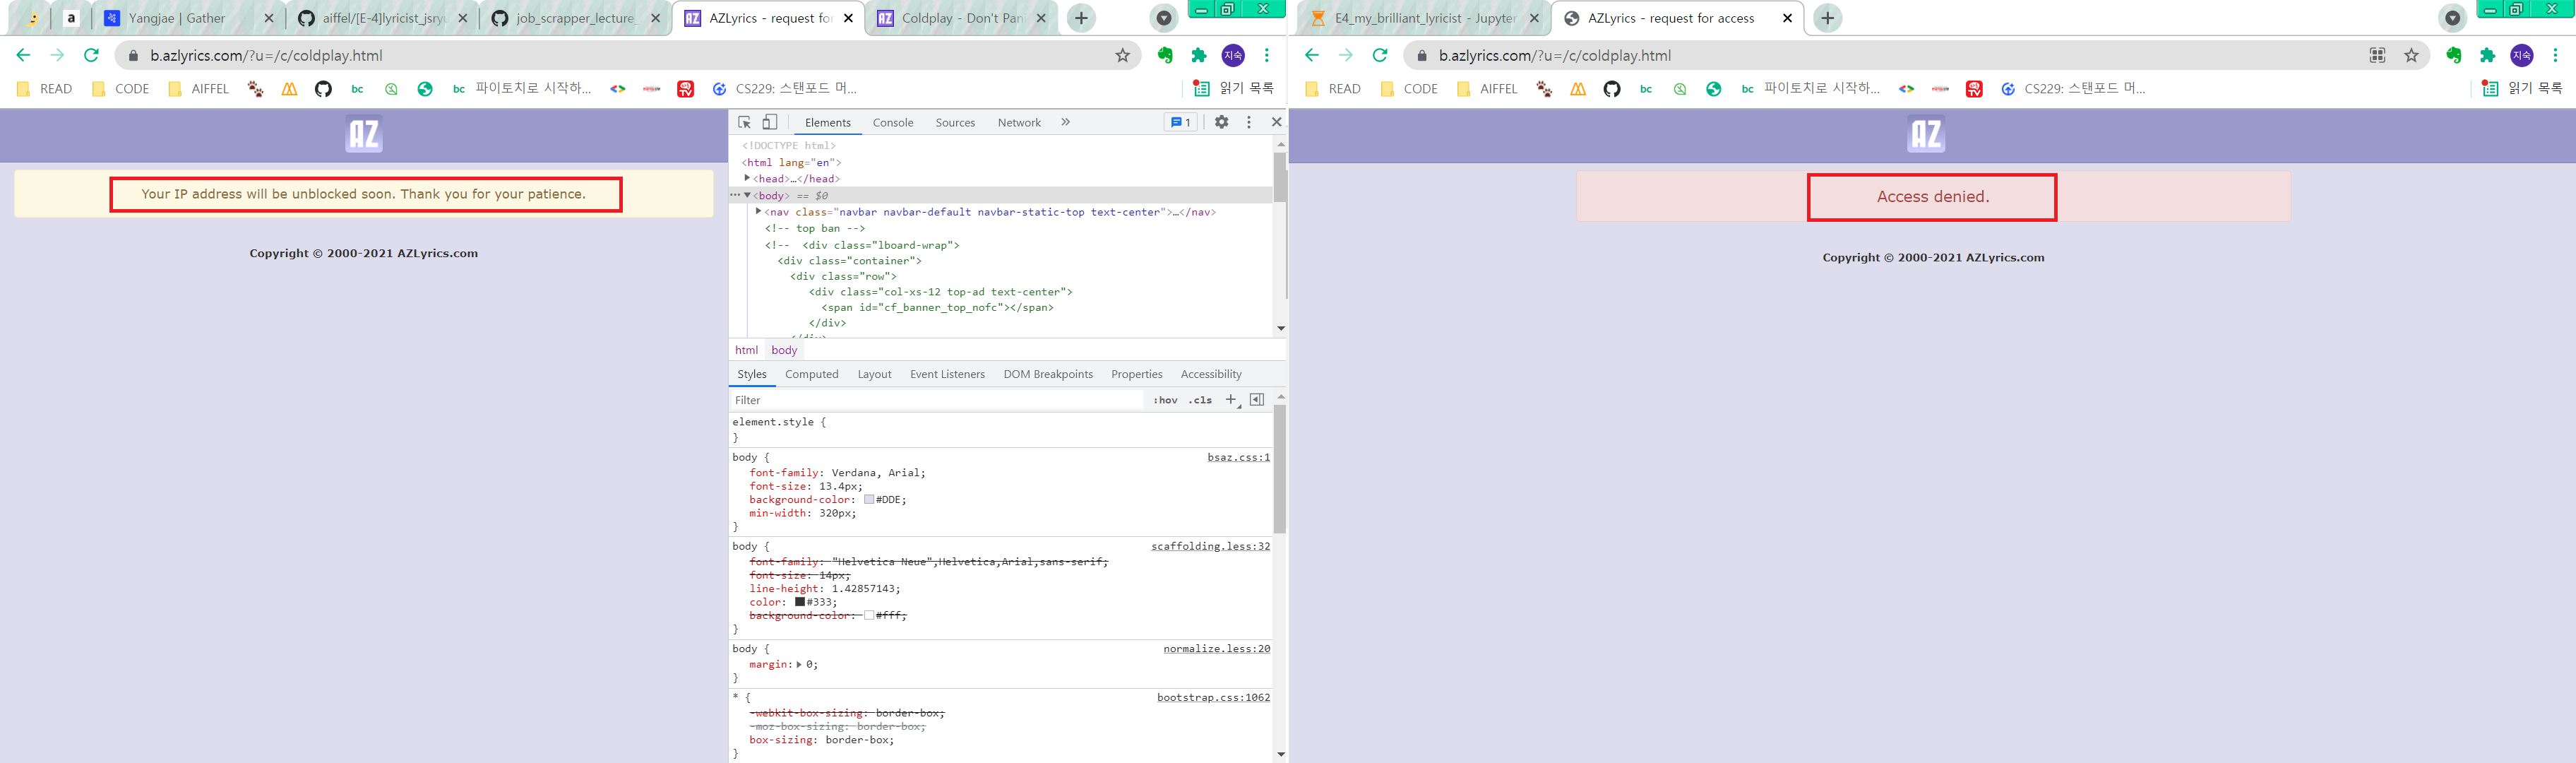

- 너무 단순한 작사가가 되지 않길 바라는 마음에서 기억할 단어를 1만 개로 변경해 주었다.
    - 7천 개로 설정했을 때와 비교해 문장 생성 능력에 큰 차이는 느껴지지 않았다.
    - 모델 학습에는 확실히 더 오랜 시간이 걸렸다. ~중간에 후회가 되었지만 그렇다고 처음부터 학습을 시작하고 싶지는 않았다.~

### 4-2. 모델 설계 및 학습 과정
- 처음에는 batch_size를 따로 주지 않고 default 값으로 학습시켜 보았다.
    - loss는 약간 더 낮게 나왔지만, 상대적으로 학습 시간이 너무 오래 걸렸기 때문에 그냥 적당한 값을 적용하는 게 경제적인 것 같다.
- 노력했지만 아직도 모델 객체의 각 파라미터 의미가 잘 이해가 가지 않는다. 잘 몰라서 적용하지 못한 것들이 많다. 더 많은 모델을 접하면서 찾아봐야겠다.
- 내용도 어려웠지만 학습에 시간이 많이 필요해서 전체적으로 더 오래 걸린 것 같다. 앞으로도 계속 프로젝트가 있을텐데, 더 빠르고 효율적인 학습을 위해 배치 사이즈 조정이나 미니배치 학습 등의 방법을 활용해볼 필요가 있을 것 같다.


### 4-3. 최종 모델 평가
- 첫 모델 학습부터 val_loss가 1.xx 대로 나왔다.
    - 첫 시도에서 노드 설명과 비교해 다른 것은 **tensor의 길이뿐**이었다.
    - 무조건 tensor 길이를 15 이하로 자르지 않고, 적당한 길이로 조정한 것이 의미 있는 문장을 학습시키는 데에 유리했던 것이 아닐까 추측해 보았다.
    - **최종 val_loss는 1.04가 나왔다.** 사실 epoch을 늘리면 더 내려갈 것이라고 생각되지만, 나중에 시간이 될 때 해봐야겠다.
    - 사실 이번 모델에서 loss라는 게 어떤 의미를 가지는지 정확히 와닿지 않았다. 이것도 더 공부해봐야겠다.
- **처음에는** 생각보다 꽤 그럴듯한 가사를 써내서 놀랐다.
    - 사실 데이터셋 중에 랩퍼가 꽤 있어서 혹시라도 거친 말을 내뱉을까봐 약간 걱정했다.
    - 처음 생성한 문장은, 'you raise'라는 input에 대해 'you raise my hand and we kissed in the moonlight'라고 한 것이었다.
    - 문법상으로는 문제가 없기 때문에 처음 봤을 때에는 약간 감동적이기까지 했는데, 사실 상상해보면 의미상으로는 터무니가 없는 문장이다.
    - 아무래도 내가 원하는 스타일의 가사를 얻으려면 데이터를 바꾸는 수밖에 없겠다.
- **고정적이고 단편적으로 생성되는 문장이 많다.**
    - 예를 들면 'let s'라는 input에 대해 **늘** 'let s go'라는 문장을 생성해냈다.
    - 가사에 잘 등장하지 않는, 조금 특이한 단어로 문장을 시작하면 여지 없이 \<unk\>으로 문장을 채웠다.
    - 예를 들면 'apple'이라는 input을 주니, \<unk\>을 연속으로 4개나 넣었다.

### 4-4. 소감
- **가장 어이 없는 문장**은 'green'이라는 input에 대해 생성된 'green eggs and ham'이라는 문장이었다. ~상상만 해도 입맛이 사라졌다~
- **가장 마음에 드는 문장**은... 없다. :)
- **진짜 좋은 문장들을 뽑아 낼 수 있는 모델을 만들고 싶어졌다.**

<br>